# mm3 Segmentation Debug Notebook

- Use this notebook to test your segmentation algorithm on your images, or right your own. 
- Then put your custom algorithm into mm3_helpers.py function segment_image

#### Load Modules

In [25]:
#!/usr/bin/python
from __future__ import print_function

# import modules
import sys
import os
import time
import inspect
import yaml
import json # for importing tiff metdata
try:
    import cPickle as pickle # pickle
except:
    import pickle
import numpy as np
import scipy.signal as spsig # used in channel finding
import scipy.stats as spstats
from scipy.optimize import curve_fit
import struct # for interpretting strings as binary data
import re # regular expressions
import traceback
import copy
import warnings
import h5py

# Image analysis modules
from scipy import ndimage as ndi
from skimage import segmentation # used in make_masks and segmentation
from skimage.feature import match_template # used to align images
from skimage.filters import threshold_otsu
from skimage import morphology # many functions is segmentation used from this
from skimage.measure import regionprops # used for creating lineages

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
# you need to import mm3_helpers
sys.path.insert(0, '../')
import mm3_helpers as mm3

### Load parameters file

- Put in the path to your parameters file!

In [5]:
param_file_path = '/Users/jt/drive/code/mm_test_data/shift_down/params_shift_down.yaml'
params = mm3.init_mm3_helpers(param_file_path)

# load specs file
with open(params['ana_dir'] + '/specs.pkl', 'r') as specs_file:
    specs = pickle.load(specs_file)

### Load some cells

- choose an FOV and Peak ID for channel that has cells in it.
- or let the code just choose the first peak with cells in it

In [70]:
# fov_id = 1
# peak_id = 28

for fov_id, peaks in specs.items():
    for peak_id, spec in peaks.items():
        if spec == 1:
            # just break out with the current fov_id and peak_id
            break
            
print('FOV %d peak %d' % (fov_id, peak_id))

FOV 2 peak 256


### Load the actual images, depending on if it is TIFF or HDF5

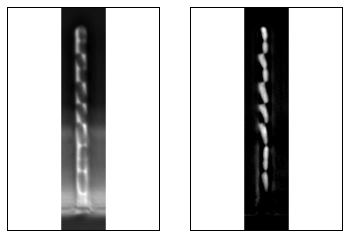

In [71]:
img_stack = mm3.load_stack(fov_id, peak_id, color='c1')
pc_img = img_stack[2]

sub_stack = mm3.load_stack(fov_id, peak_id, color='sub')
# take first time point
sub_img = sub_stack[2]

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(pc_img, cmap=plt.cm.gray)
ax[1].imshow(sub_img, cmap=plt.cm.gray)

for axis in axes:
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
plt.show()

# Segment image algorithms

- Each block is a different algorithm. 

## threshold, distance matrix, and diffusion/watershed

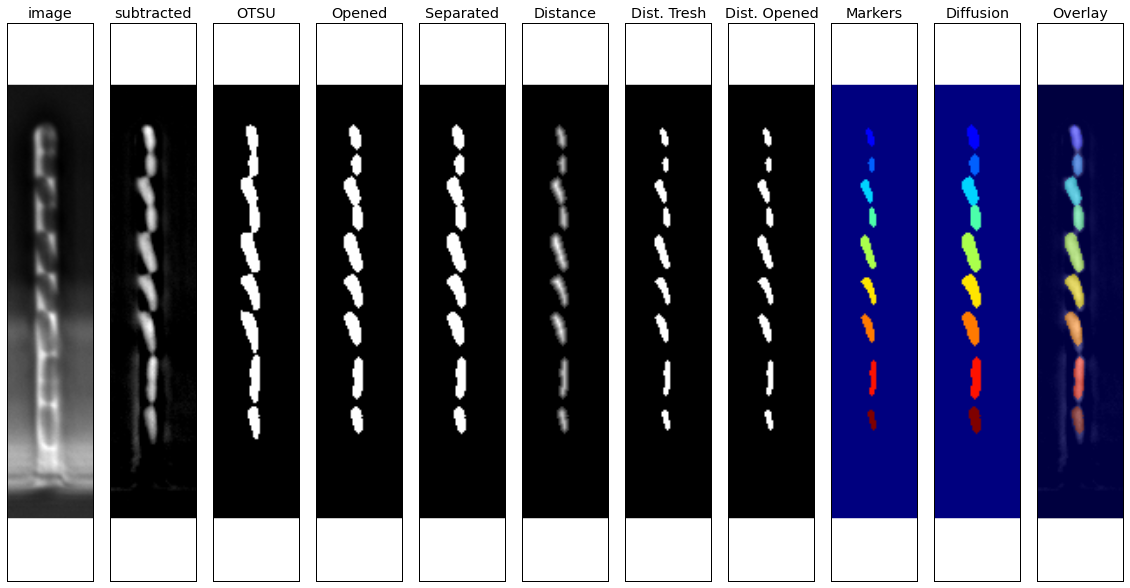

In [73]:
# threshold image
thresh = threshold_otsu(sub_img) # finds optimal OTSU thershhold value
threshholded = sub_img > thresh # will create binary image

# if there are no cells, good to clear the border
# because otherwise the OTSU is just for random bullshit, most
# likely on the side of the image
threshholded = segmentation.clear_border(threshholded)

thresholded_plot = threshholded.copy()

# Morphological operations
# tool for transformations
tool = morphology.disk(2)

# Opening = erosion then dialation.
# opening smooths images, breaks isthmuses, and eliminates protrusions.
# "opens" dark gaps between bright features.
morph = morphology.binary_opening(threshholded, tool)

opening_plot = morph.copy()

# if this image is empty at this point (likely if there were no cells), just return
# the morphed image which is a zero array
if np.amax(morph) == 0:
    print('No cells in after thresholding and opening')
    pass

# zero out rows that have very few pixels
# widens or creates gaps between cells
# sum of rows (how many pixels are occupied in each row)
line_profile = np.sum(morph, axis=1)
# find highest value, aka width of fattest cell
max_width = max(line_profile)
# find indexes of rows where sum is less than 1/5th of this value.
zero_these_indicies = np.all([line_profile < (max_width/5), line_profile > 0], axis=0)
zero_these_indicies = np.where(zero_these_indicies)
# zero out those rows
morph[zero_these_indicies] = 0

separated_plot = morph.copy()

### Calculate distnace matrix, use as markers for random walker (diffusion watershed)
# Generate the markers based on distance to the background
distance = ndi.distance_transform_edt(morph)
distance_plot = distance.copy()


# threshold distance image
distance_thresh = np.zeros_like(distance)
distance_thresh[distance < 2] = 0
distance_thresh[distance >= 2] = 1
distance_thresh_plot = distance_thresh.copy()

# do an extra opening on the distance
distance_opened = morphology.binary_opening(distance_thresh, morphology.disk(1))
distance_opened_plot = distance_opened.copy()

# remove artifacts connected to image border
cleared = segmentation.clear_border(distance_opened)
# remove small objects. Remove small objects wants a
# labeled image and will fail if there is only one label. Return zero image in that case
# could have used try/except but remove_small_objects loves to issue warnings.
cleared, label_num = morphology.label(cleared, connectivity=1, return_num=True)
if label_num > 1:
    cleared = morphology.remove_small_objects(cleared, min_size=20)
else:
    pass

# relabel now that small objects and labels on edges have been cleared
markers = morphology.label(cleared)
markers_plot = markers.copy()

# label using the random walker (diffusion watershed) algorithm
# set anything outside of OTSU threshold to -1 so it will not be labeled
markers[morph == 0] = -1
# here is the main algorithm
labeled_image = segmentation.random_walker(-1*sub_img, markers)
# put negative values back to zero for proper image
labeled_image[labeled_image == -1] = 0

# or watershed
# labeled_image = morphology.watershed(-1*sub_img, markers, mask=morph)


### Plot it up. 
fig, axes = plt.subplots(ncols=11, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title('image')
ax[0].imshow(pc_img, cmap=plt.cm.gray)

ax[1].set_title('subtracted')
ax[1].imshow(sub_img, cmap=plt.cm.gray)

ax[2].set_title('OTSU')
ax[2].imshow(thresholded_plot, cmap=plt.cm.gray)

ax[3].set_title('Opened')
ax[3].imshow(opening_plot, cmap=plt.cm.gray)

ax[4].set_title('Separated')
ax[4].imshow(separated_plot, cmap=plt.cm.gray)

ax[5].set_title('Distance')
ax[5].imshow(distance_plot, cmap=plt.cm.gray)

ax[6].set_title('Dist. Tresh')
ax[6].imshow(distance_thresh_plot, cmap=plt.cm.gray)

ax[7].set_title('Dist. Opened')
ax[7].imshow(distance_opened_plot, cmap=plt.cm.gray)

ax[8].set_title('Markers')
ax[8].imshow(markers_plot)

ax[9].set_title('Diffusion')
ax[9].imshow(labeled_image)

ax[10].set_title('Overlay')
ax[10].imshow(sub_img, cmap=plt.cm.gray)
ax[10].imshow(labeled_image, alpha=0.5)

for axis in axes:
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)